In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from copy import deepcopy
from utils import *
import seaborn as sns
from torchvision.transforms import ToTensor
torch.manual_seed(12345)
print(torch.__version__, torchvision.__version__)
from utils import *
%load_ext autoreload
%autoreload 2

2.3.1+cu121 0.18.1+cu121


In [2]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Files already downloaded and verified
Running on cuda


In [43]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

## Good seed with faster convergence

In [4]:
model = torch.load("model.pth")
net = LeNet().to(device)
net.load_state_dict(model)

<All keys matched successfully>

In [5]:
# # share the gradients with other clients
# original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
# sparse_dy_dx = list((_.detach().clone() for _ in dy_dx_))
# fixed_point_dy_dx = list((_.detach().clone() for _ in dy_dx_))
# stochastic_rounding_dy_dx = list((_.detach().clone() for _ in dy_dx_))
# kmeans_dy_dx = list((_.detach().clone() for _ in dy_dx_))
# log_dy_dx = list((_.detach().clone() for _ in dy_dx_))

GT label is 84. 
Onehot label is 84.


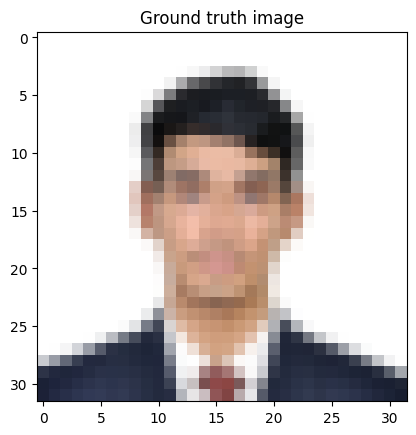

In [15]:
######### honest partipant #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)

gt_data = tp(Image.open('images/me.jpg')).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())


# Uniform Quantization

In [7]:

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = uniform_quantization(grad,120)
    quantized_dy_dx.append(quantized_grad)


# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))



In [8]:
histories1 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_quantized_dy_dx, tt)
    histories1.append(history)

Experiment 1
Dummy label is 97.
0 130.1586
10 86.7828
20 67.8138
30 58.9603
40 53.4328
50 46.7297
60 41.7525
70 36.6588
80 33.3084
90 29.3188
Experiment 2
Dummy label is 91.
0 44.2655
10 0.9220
20 0.3441
30 0.2825
40 0.2714
50 0.2677
60 0.2663
70 0.2656
80 0.2652
90 0.2649
Experiment 3
Dummy label is 90.
0 57.9890
10 1.1882
20 0.3590
30 0.2888
40 0.2762
50 0.2722
60 0.2704
70 0.2692
80 0.2661
90 0.2656
Experiment 4
Dummy label is 50.
0 750.0581
10 631.6143
20 607.1432
30 594.8063
40 587.1367
50 583.3445
60 579.5729
70 576.6658
80 574.7665
90 572.8206
Experiment 5
Dummy label is 41.
0 159.8305
10 2.1668
20 0.4730
30 0.3153
40 0.2846
50 0.2736
60 0.2697
70 0.2678
80 0.2667
90 0.2661


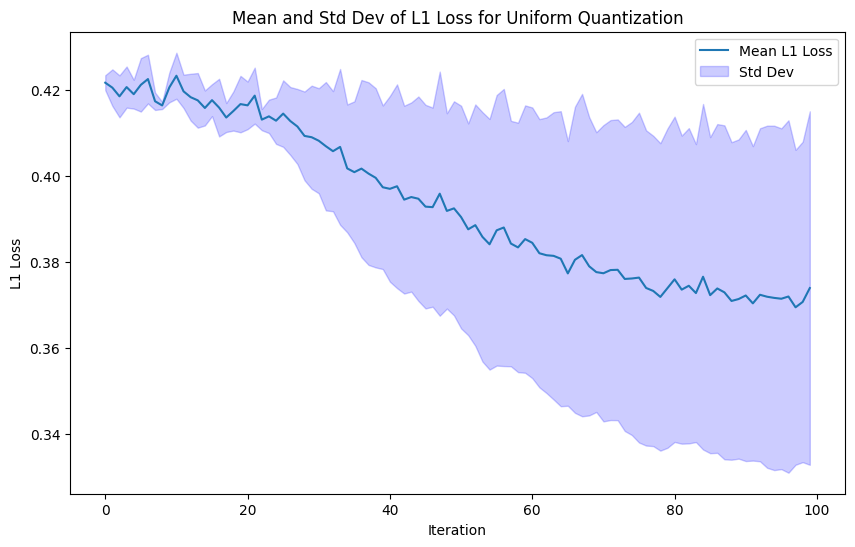

In [12]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories1:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Uniform Quantization")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

# No Quantization

In [16]:

# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [17]:
histories2 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_dy_dx, tt)
    histories2.append(history)

Experiment 1
Dummy label is 11.
0 55.2690
10 0.9229
20 0.1134
30 0.0236
40 0.0085
50 0.0040
60 0.0020
70 0.0011
80 0.0006
90 0.0004
Experiment 2
Dummy label is 76.
0 812.3611
10 1052.7939
20 1052.7939
30 1052.7939
40 1052.7939
50 1052.7939
60 1052.7939
70 1052.7939
80 1052.7939
90 1052.7939
Experiment 3
Dummy label is 79.
0 54.2973
10 0.7814
20 0.0865
30 0.0202
40 0.0068
50 0.0030
60 0.0014
70 0.0007
80 0.0004
90 0.0002
Experiment 4
Dummy label is 79.
0 44.6366
10 0.7511
20 0.0835
30 0.0209
40 0.0086
50 0.0041
60 0.0020
70 0.0011
80 0.0006
90 0.0004
Experiment 5
Dummy label is 28.
0 58.6170
10 0.6071
20 0.0684
30 0.0191
40 0.0080
50 0.0038
60 0.0019
70 0.0011
80 0.0006
90 0.0004


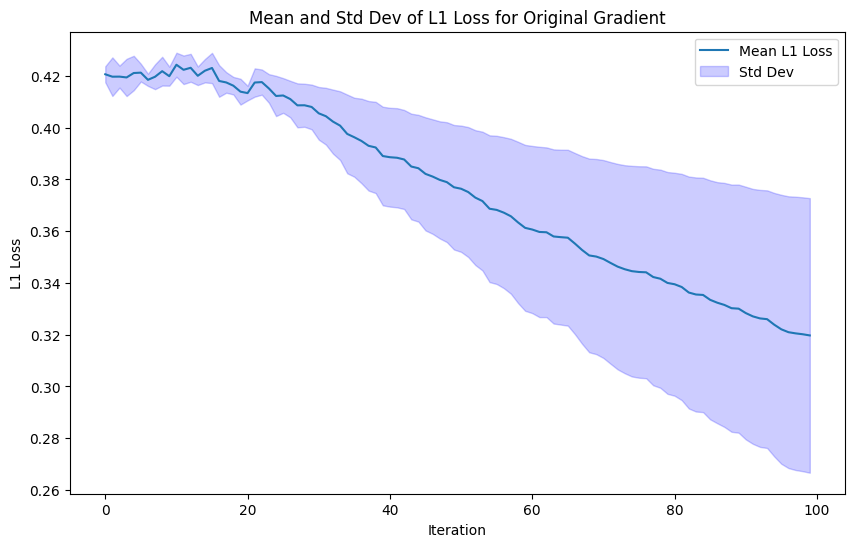

In [18]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories2:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Original Gradient")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

# Sparsity Quantization

In [19]:
# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = add_sparsity(grad,sparsity_ratio=0.1)
    quantized_dy_dx.append(quantized_grad)


# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))


In [20]:
histories3 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_quantized_dy_dx, tt)
    histories3.append(history)

Experiment 1
Dummy label is 15.
0 75.6875
10 1.1139
20 0.1392
30 0.0555
40 0.0368
50 0.0305
60 0.0280
70 0.0270
80 0.0265
90 0.0262
Experiment 2
Dummy label is 50.
0 38.0000
10 0.8874
20 0.1335
30 0.0520
40 0.0359
50 0.0306
60 0.0283
70 0.0272
80 0.0266
90 0.0263
Experiment 3
Dummy label is 27.
0 46.3124
10 0.7230
20 0.1128
30 0.0449
40 0.0336
50 0.0292
60 0.0275
70 0.0267
80 0.0263
90 0.0261
Experiment 4
Dummy label is 28.
0 124.7800
10 308.8817
20 308.8817
30 308.8817
40 308.8817
50 308.8817
60 308.8817
70 308.8817
80 308.8817
90 308.8817
Experiment 5
Dummy label is 29.
0 81.2973
10 1.4870
20 0.2003
30 0.0707
40 0.0413
50 0.0333
60 0.0299
70 0.0281
80 0.0272
90 0.0267


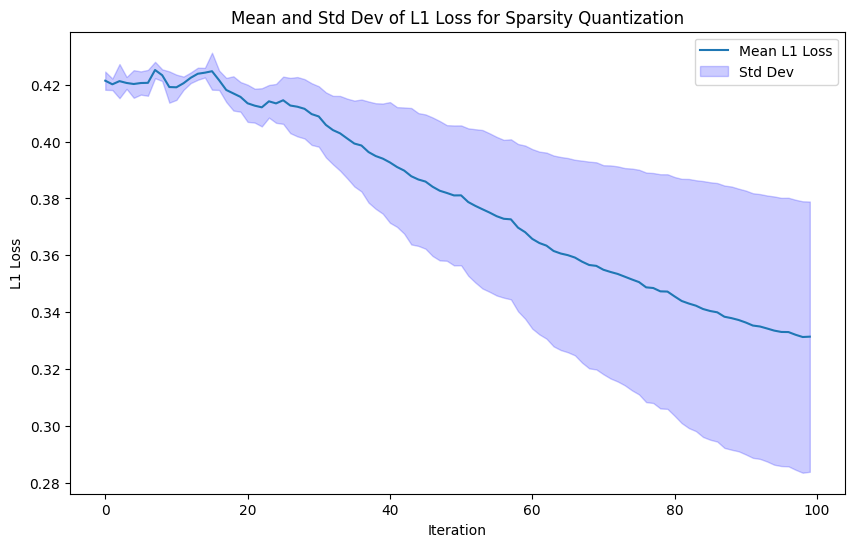

In [21]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories3:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Sparsity Quantization")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

# Stochastic Quantization

In [22]:
# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = stochastic_rounding(grad,240)
    quantized_dy_dx.append(quantized_grad)


# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))

In [23]:
histories4 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_quantized_dy_dx, tt)
    histories4.append(history)

Experiment 1
Dummy label is 78.
0 69.6735
10 1.5111
20 0.4585
30 0.3677
40 0.3501
50 0.3453
60 0.3434
70 0.3424
80 0.3420
90 0.3417
Experiment 2
Dummy label is 88.
0 48.0392
10 1.2998
20 0.4544
30 0.3674
40 0.3504
50 0.3450
60 0.3430
70 0.3422
80 0.3418
90 0.3416
Experiment 3
Dummy label is 26.
0 76.4466
10 6.1630
20 1.8906
30 0.9095
40 0.6225
50 0.5144
60 0.4581
70 0.4266
80 0.4063
90 0.3961
Experiment 4
Dummy label is 26.
0 39.7010
10 0.9205
20 0.4195
30 0.3607
40 0.3494
50 0.3451
60 0.3432
70 0.3423
80 0.3419
90 0.3416
Experiment 5
Dummy label is 1.
0 523.7385


/home/dell/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


10 546.3201
20 546.3201
30 546.3201
40 546.3201
50 546.3201
60 546.3201
70 546.3201
80 546.3201
90 546.3201


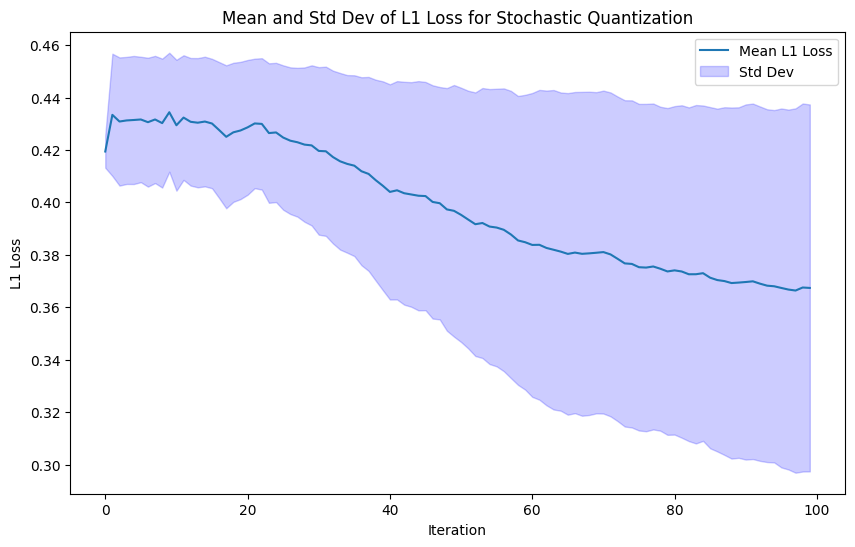

In [24]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories4:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Stochastic Quantization")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

In [26]:
import pickle
with open('histories1.pkl', 'wb') as file:
    pickle.dump(histories1, file)

# Save histories2 to histories2.pkl
with open('histories2.pkl', 'wb') as file:
    pickle.dump(histories2, file)

# Save histories3 to histories3.pkl
with open('histories3.pkl', 'wb') as file:
    pickle.dump(histories3, file)

# Save histories4 to histories4.pkl
with open('histories4.pkl', 'wb') as file:
    pickle.dump(histories4, file)

# Train the Model

In [32]:
# CIFAR-10 data loading and transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
train_losses, test_losses, test_accuracies, net = train(net, 1, testloader, trainloader, 3,None, None)

Epoch 1, Train_Loss: 0.0014415715026855468
Epoch 1, Test_Loss: 5.502672832155228
Accuracy: 10.0%
###########################################
Finished Training


### Reconstruction from Original Gradients after Training

In [47]:
# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [48]:
histories_trained_2 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_dy_dx, tt)
    histories_trained_2.append(history)

Experiment 1
Dummy label is 38.
0 0.2509
10 0.0158
20 0.0065
30 0.0033
40 0.0011
50 0.0007
60 0.0005
70 0.0003
80 0.0003
90 0.0002
Experiment 2
Dummy label is 39.
0 0.1863
10 0.0035
20 0.0007
30 0.0003
40 0.0001
50 0.0001
60 0.0001
70 0.0001
80 0.0000
90 0.0000
Experiment 3
Dummy label is 46.
0 0.2001
10 0.0032
20 0.0006
30 0.0002
40 0.0001
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000
Experiment 4
Dummy label is 70.
0 0.2145
10 0.0059
20 0.0008
30 0.0002
40 0.0001
50 0.0001
60 0.0000
70 0.0000
80 0.0000
90 0.0000
Experiment 5
Dummy label is 99.
0 0.1670
10 0.0033
20 0.0007
30 0.0003
40 0.0002
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000


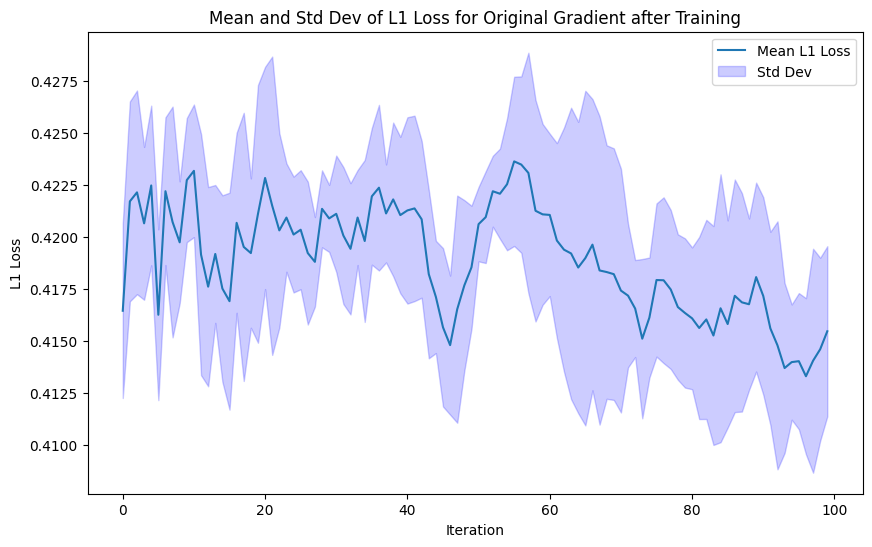

In [49]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories_trained_2:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Original Gradient after Training")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

### Reconstruction from Uniform Quantized Gradients after Training

In [50]:
# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = uniform_quantization(grad,120)
    quantized_dy_dx.append(quantized_grad)


# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))

In [51]:
histories_trained_1 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_dy_dx, tt)
    histories_trained_1.append(history)

Experiment 1
Dummy label is 15.
0 0.2342
10 0.0043
20 0.0009
30 0.0003
40 0.0002
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000
Experiment 2
Dummy label is 80.
0 0.2163
10 0.0048
20 0.0010
30 0.0004
40 0.0002
50 0.0001
60 0.0001
70 0.0001
80 0.0001
90 0.0000
Experiment 3
Dummy label is 41.
0 0.2082
10 0.0030
20 0.0006
30 0.0002
40 0.0001
50 0.0001
60 0.0000
70 0.0000
80 0.0000
90 0.0000
Experiment 4
Dummy label is 60.
0 0.2841
10 0.0058
20 0.0016
30 0.0007
40 0.0004
50 0.0002
60 0.0002
70 0.0001
80 0.0001
90 0.0001
Experiment 5
Dummy label is 88.
0 0.2768
10 0.0097
20 0.0024
30 0.0011
40 0.0006
50 0.0004
60 0.0003
70 0.0002
80 0.0002
90 0.0001


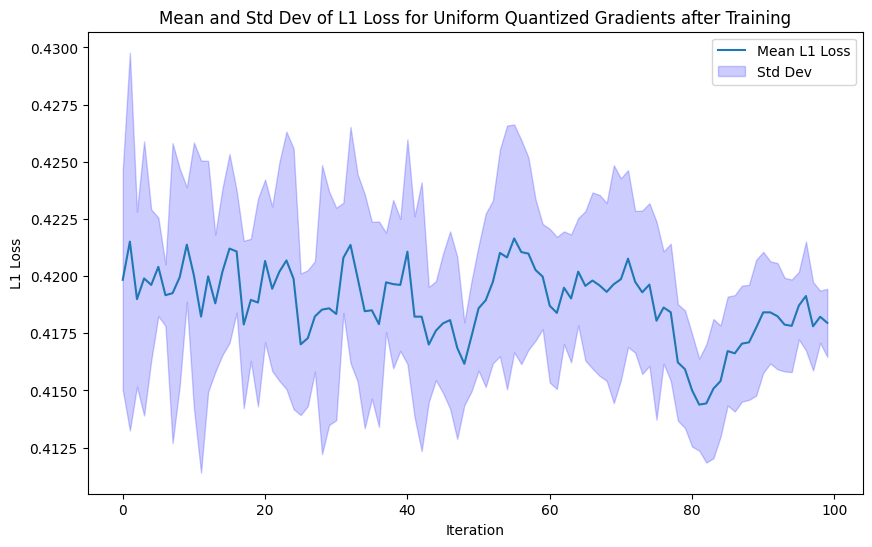

In [52]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories_trained_1:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Uniform Quantized Gradients after Training")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

### Reconstruction from Stochastic Quantized Gradients after Training

In [53]:
# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = stochastic_rounding(grad,240)
    quantized_dy_dx.append(quantized_grad)


# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))

In [54]:
histories_trained_3 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_dy_dx, tt)
    histories_trained_3.append(history)

Experiment 1
Dummy label is 35.
0 0.1470
10 0.0039
20 0.0007
30 0.0003
40 0.0002
50 0.0001
60 0.0001
70 0.0001
80 0.0000
90 0.0000
Experiment 2
Dummy label is 81.
0 0.2775
10 0.0094
20 0.0016
30 0.0006
40 0.0003
50 0.0002
60 0.0001
70 0.0001
80 0.0001
90 0.0000
Experiment 3
Dummy label is 29.
0 0.1036
10 0.0024
20 0.0005
30 0.0002
40 0.0001
50 0.0000
60 0.0000
70 0.0000
80 0.0000
90 0.0000
Experiment 4
Dummy label is 26.
0 0.1310
10 0.0057
20 0.0009
30 0.0003
40 0.0001
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000
Experiment 5
Dummy label is 66.
0 0.1800
10 0.0034
20 0.0007
30 0.0003
40 0.0002
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000


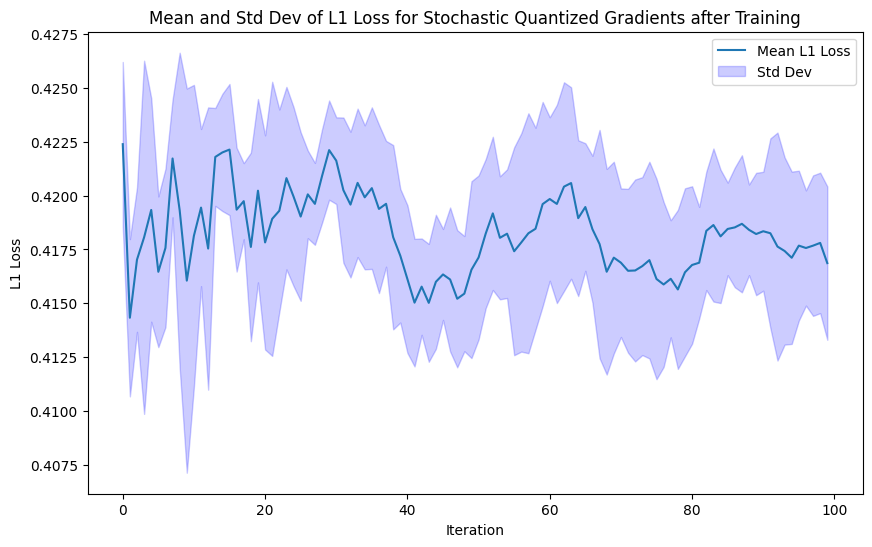

In [55]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories_trained_3:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Stochastic Quantized Gradients after Training")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

### Reconstruction from Sparse Quantized Gradients after Training

In [56]:
# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx_))
import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = add_sparsity(grad,sparsity_ratio=0.1)
    quantized_dy_dx.append(quantized_grad)


# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))

In [57]:
histories_trained_4 = []

for i in range(5):
    print(f"Experiment {i+1}")
    
    # Generate dummy data and labels
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
    
    # Plot the dummy data
    # plt.imshow(tt(dummy_data[0].cpu()))
    # plt.title("Dummy data")
    # plt.show()
    
    # Print the dummy label
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
    
    # Perform reconstruction and save the history
    history = reconstruct(net, dummy_data, dummy_label, original_dy_dx, tt)
    histories_trained_4.append(history)

Experiment 1
Dummy label is 9.
0 0.2726
10 0.0038
20 0.0010
30 0.0004
40 0.0002
50 0.0001
60 0.0001
70 0.0001
80 0.0001
90 0.0000
Experiment 2
Dummy label is 34.
0 0.1427
10 0.0038
20 0.0008
30 0.0003
40 0.0001
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000
Experiment 3
Dummy label is 41.
0 0.1940
10 0.0038
20 0.0008
30 0.0003
40 0.0002
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000
Experiment 4
Dummy label is 43.
0 0.2516
10 0.0034
20 0.0007
30 0.0002
40 0.0001
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000
Experiment 5
Dummy label is 46.
0 0.1369
10 0.0032
20 0.0007
30 0.0003
40 0.0002
50 0.0001
60 0.0001
70 0.0000
80 0.0000
90 0.0000


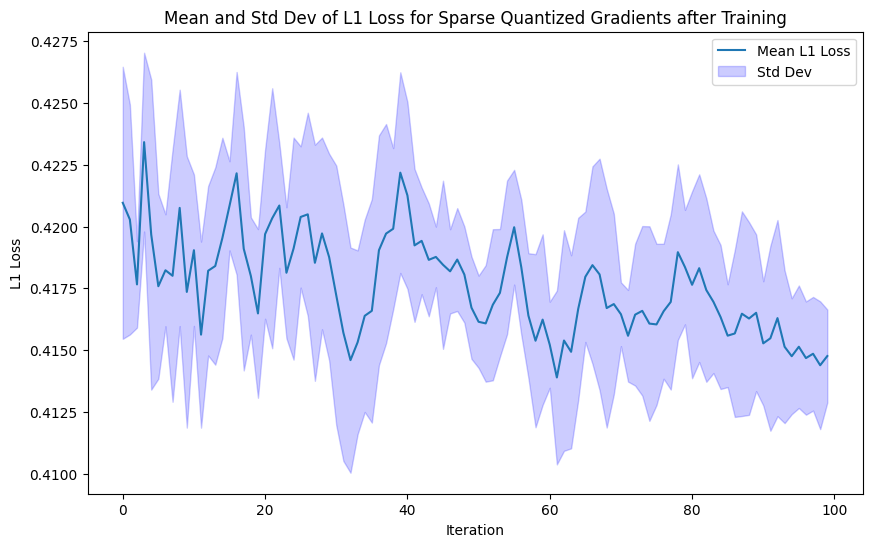

In [58]:
# Calculate L1 loss for all experiments
all_l1_losses = []

gt_tensor = gt_data[0].to(device)

for history in histories_trained_4:
    l1_losses = []
    for img_tensor in history:
        transform = ToTensor()
        img_tensor = transform(img_tensor).to(device)
        l1_loss = torch.mean(torch.abs(img_tensor - gt_tensor)).item()
        l1_losses.append(l1_loss)
    all_l1_losses.append(l1_losses)

# Convert to numpy array for easier manipulation
all_l1_losses = np.array(all_l1_losses)

# Calculate mean and standard deviation
mean_l1_loss = np.mean(all_l1_losses, axis=0)
std_l1_loss = np.std(all_l1_losses, axis=0)

# Plotting
iterations = range(all_l1_losses.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_l1_loss, label='Mean L1 Loss')
plt.fill_between(iterations, mean_l1_loss - std_l1_loss, mean_l1_loss + std_l1_loss, color='b', alpha=0.2, label='Std Dev')
plt.title("Mean and Std Dev of L1 Loss for Sparse Quantized Gradients after Training")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")
plt.legend()
plt.show()

In [ ]:
import pickle
with open('histories1.pkl', 'wb') as file:
    pickle.dump(histories_trained_1, file)

# Save histories2 to histories2.pkl
with open('histories2.pkl', 'wb') as file:
    pickle.dump(histories_trained_2, file)

# Save histories3 to histories3.pkl
with open('histories3.pkl', 'wb') as file:
    pickle.dump(histories_trained_3, file)

# Save histories4 to histories4.pkl
with open('histories4.pkl', 'wb') as file:
    pickle.dump(histories_trained_4, file)